## Image Analysis Techniques to Detect Triple Lines
This looks at grain boundary atoms as defined by Ovitos using PTM and attempts to find intersection points which are potential triple lines. The main routine converted the atom positions into an integer array position initially form a square grid of side length $a=4.05$. The issue then becomes looking at the neighbouring squares to determine whether this is a grain boundary or potential triple line. At present the issue is more complicated as the skeletonize command is not consistently reduing the image to a continous set of curves all of which are one pixel wide.

In [45]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import LatticeDefinitions as ld
import GeometryFunctions as gf
import GeneralLattice as gl
import LAMMPSDump as LD
import scipy as sc
from skimage.morphology import skeletonize, thin, medial_axis
import os
from skimage.measure import label, regionprops
from IPython.core.debugger import set_trace

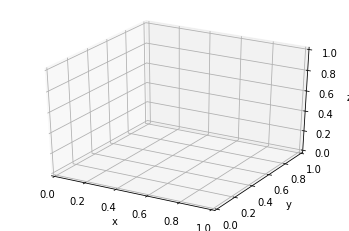

In [46]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
a1 = 4.05 ##lattice parameter
a2 = a1*np.sqrt(3) #periodic cell repeat multiple
l = 3
h= 4
z = a2*np.array([0,0,h])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
strDataFile = 'new.data'
#strDumpFile = 'dump.eam'
strDumpFile = 'data/60and30.eam'
strPMFile = strDumpFile + 'PM'
arr111BasisVectors = gf.RotatedBasisVectors(np.arccos(1/np.sqrt(3)), np.array([1,-1,0])/np.sqrt(2))
arrHorizontalVector = np.array([l*a2,0,0])
arrDiagonalVector =  np.array([a2*l/2, a2*l*np.sqrt(3)/2,0]);

In [47]:
MySimulationCell = gl.SimulationCell(np.array([3*arrHorizontalVector,3*arrDiagonalVector, z])) 
objHex1 = gl.ExtrudedRegularPolygon(l*a2, h*a2, 6, arr111BasisVectors, ld.FCCCell, np.array([a1,a1,a1]))
objHex2 = gl.ExtrudedRegularPolygon(l*a2, h*a2, 6, gf.RotateVectors(gf.DegreesToRadians(20),z, arr111BasisVectors), ld.FCCCell, np.array([a1,a1,a1]),-arrDiagonalVector+2*arrHorizontalVector)
objHex3 = gl.ExtrudedRegularPolygon(l*a2, h*a2, 6, gf.RotateVectors(gf.DegreesToRadians(40),z,arr111BasisVectors), ld.FCCCell, np.array([a1,a1,a1]), arrHorizontalVector + arrDiagonalVector)
MySimulationCell.AddGrain(objHex1)
MySimulationCell.AddGrain(objHex2)
MySimulationCell.AddGrain(objHex3)
MySimulationCell.WrapAllPointsIntoSimulationCell()
MySimulationCell.RemovePlaneOfAtoms(np.array([[0,0,1,a2*h]]),0.1)
#MySimulationCell.WriteLAMMPSDataFile(strDataFile)

In [48]:
objData = LD.LAMMPSData(strPMFile)
objTimeStep = objData.GetTimeStepByIndex(0)
objTimeStep.StandardiseOrientationData()
objPostProcess = LD.OVITOSPostProcess(np.array([objHex1.GetQuaternionOrientation(), 
                                                objHex2.GetQuaternionOrientation(), 
                                                objHex3.GetQuaternionOrientation()]), objTimeStep, 1)

In [49]:
MyData = np.zeros([objTimeStep.GetNumberOfAtoms(),5])
MyData[:,0:3] = objTimeStep.GetAtomData()[:,1:4]
MyData[:,3] = objTimeStep.GetAtomData()[:,7]
MyData[:,4] = objTimeStep.GetAtomData()[:,8]
print(MyData[:,0:5])

[[ 1.66972010e+00  5.10324000e-01  3.91190000e-02 -3.14520000e+00
   0.00000000e+00]
 [ 1.13557990e+00  9.06263000e-01  2.90847000e+00 -3.16948010e+00
   0.00000000e+00]
 [ 2.67566990e+00  2.65037990e+00  6.89835980e+00 -3.11216000e+00
   0.00000000e+00]
 ...
 [ 3.38328003e+02  1.93238998e+02  4.02210000e+00 -3.31884000e+00
   1.00000000e+00]
 [ 3.38291992e+02  1.97639008e+02  2.17252990e+00 -3.31151010e+00
   1.00000000e+00]
 [ 3.38381012e+02  1.97485993e+02  6.19514990e+00 -3.32966000e+00
   1.00000000e+00]]


In [50]:
fltA = a1

In [51]:
# def QuantisedVector(inVector: np.array)->np.array:
#     intCol = np.argmax(np.abs(inVector))
#     arrReturn = np.zeros([np.round(inVector[intCol]).astype('int')+1,2])
#     fltRatio = 1
#     if inVector[intCol] != 0:
#         fltRatio = inVector[intCol-1]/inVector[intCol]
#     for j in range(len(arrReturn)):
#         arrReturn[j,intCol] = j
#         arrReturn[j, 1-intCol] = np.floor((j+0.5)*fltRatio)   
#     return arrReturn.astype('int')

None
[0 1]


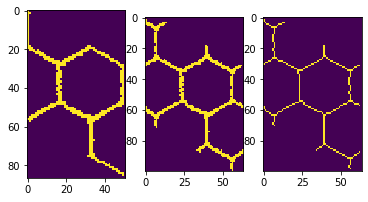

In [52]:
class QuantisedPoints(object):
    def __init__(self, in2DPoints: np.array, infltSideLength: float, inBoundaryVectors: np.array, intWrapperWidth: int):
        self.__GridLength = infltSideLength
        self.__DataPoints = in2DPoints
        self.__MaxX = np.max(in2DPoints[:,0])
        self.__MaxY = np.max(in2DPoints[:,1])
        self.__WrapperWidth = intWrapperWidth
        self.QuantisedVectors(infltSideLength,inBoundaryVectors)
        self.Skeletonised = False
        self.MakeGrid()
        self.ExtendGrid()
    def MakeGrid(self): 
        arrReturn = np.zeros([np.ceil(self.__MaxX/self.__GridLength+1).astype('int'),np.ceil(self.__MaxY/self.__GridLength+1).astype('int')])
        for j in self.__DataPoints:
            if j[4].astype('int') ==0:
                arrReturn[(np.floor(j[0]/self.__GridLength)).astype('int'),(np.floor(j[1]/self.__GridLength)).astype('int')] +=1
        self.__GridArray = arrReturn.astype('bool').astype('int')
        self.__Height, self.__Width = np.shape(arrReturn)
    def ExtendGrid(self): #2n excess rows and columns around the GB array
        n = self.__WrapperWidth
        self.__ExtendedGrid = np.zeros([np.ceil(self.__MaxX/self.__GridLength+2*n).astype('int'),
                                        np.ceil(self.__MaxY/self.__GridLength +2*n).astype('int')])
        self.__ExtendedGrid[n: -n+1, n: -n+1] = self.__GridArray.astype('int')                                
    def CopyGBToWrapper(self,arrPoints: np.array, arrShift: np.array, intValue =1):
         for j in arrPoints:
            if self.__ExtendedGrid[j[0], j[1]] ==1 or self.__ExtendedGrid[j[0], j[1]] ==2:
                self.__ExtendedGrid[j[0]+arrShift[0],j[1]+arrShift[1]] = intValue                                                   
    def QuantisedVectors(self,infltSize: float, inBoundaryVectors: np.array):
        self.__QVectors = np.array([gf.QuantisedVector(inBoundaryVectors[0]/infltSize),gf.QuantisedVector(inBoundaryVectors[1]/infltSize)]) 
    def GetQVectors(self)->np.array:
        return self.__QVectors
    def GetExtendedGrid(self)->np.array:
        return self.__ExtendedGrid
    def GetGrid(self)->np.array:
        return self.__GridArray
    def CopyPointsToWrapper(self):
        arrWrapperVector = np.array([self.__WrapperWidth, self.__WrapperWidth])
        vctDown = self.__QVectors[0]#assumes vertically down
        vctAcross = self.__QVectors[1]#assumes diagonal going right and possibly down or  up
        vctExtDown = gf.ExtendQuantisedVector(self.__QVectors[0][-1],2*self.__WrapperWidth)
        vctAcrossTranslation = np.array([0,self.__WrapperWidth])
        vctExtDown = vctExtDown + vctAcrossTranslation
        vctExtAcross = gf.ExtendQuantisedVector(self.__QVectors[1][-1],2*self.__WrapperWidth)
        vctDownTranslation = np.array([self.__WrapperWidth - vctAcross[self.__WrapperWidth][0],0])
        vctExtAcross = vctExtAcross + vctDownTranslation
        for k in range(self.__WrapperWidth+1):
            self.CopyGBToWrapper(vctExtAcross+vctDown[k], vctDown[-1])
            self.CopyGBToWrapper(vctExtAcross+vctDown[-1]-vctDown[k], -vctDown[-1])
            self.CopyGBToWrapper(vctExtDown+vctAcross[k], vctAcross[-1])
            self.CopyGBToWrapper(vctExtDown+vctAcross[-1] -vctAcross[k], -vctAcross[-1])
    def GetSkeletonPoints(self):
        if not self.Skeletonised:
            self.SkeletonisePoints()
        return self.__SkeletonGrid
    def SetSkeletonValue(self, arrPosition:np.array, intValue):
        self.__SkeletonGrid[arrPosition[0],arrPosition[1]] = intValue
    def SkeletonisePoints(self):
        if not self.Skeletonised:
            arrOutSk = skeletonize(self.GetExtendedGrid())
            arrOutSk = thin(arrOutSk)
            self.__SkeletonGrid = arrOutSk.astype('int')
            self.Skeletonised = True
    def ClassifyGBPoints(self,m:int,blnFlagEndPoints = False)->np.array:
        self.SkeletonisePoints()
        arrTotal =np.zeros(4*m)
        intLow = int((m-1)/2)
        intHigh = int((m+1)/2)
        arrArgList = np.argwhere(self.__SkeletonGrid==1)
        arrCurrent = np.zeros([m,m])
        for x in arrArgList: #loop through the array positions which have GB atoms
            arrCurrent = self.__SkeletonGrid[x[0]-intLow:x[0]+intHigh,x[1]-intLow:x[1]+intHigh] #sweep out a m x m square of array positions with
            intSwaps = 0
        if np.shape(arrCurrent) == (m,m): #centre j. This check avoids boundary points
            intValue = arrCurrent[0,0]
            arrTotal[:m ] = arrCurrent[0,:]
            arrTotal[m:2*m] =  arrCurrent[:,-1]
            arrTotal[2*m:3*m] = arrCurrent[-1,::-1]
            arrTotal[3*m:4*m] = arrCurrent[-1::-1,0]
            for k in arrTotal:
                if (k!= intValue): #the move has changed from grain (int 0) to grain boundary (int 1) or vice versa
                    intSwaps += 1
                    intValue = k
            if intSwaps == 6:
                if not (arrCurrent[0].all() == 1 or arrCurrent[-1].all() == 1 or arrCurrent[:,0].all() == 1 or arrCurrent[:,-1].all() ==1):
                    #self.__SkeletonGrid[x[0],x[1]]=2 #this is a triple point
                    self.SetSkeletonValue(x,3)
            if intSwaps < 4:
                if blnFlagEndPoints:
                   # self.__SkeletonGrid[x[0],x[1]]=3   #this is where a GB terminates without being a triple point
                    self.SetSkeletonValue(x,2)
            return arrArgList
objQPoints = QuantisedPoints(MyData, fltA, objTimeStep.GetCellVectors()[0:2,0:2],7) 
fig,ax = plt.subplots(1,3)
ax[0].imshow(objQPoints.GetGrid())
objQPoints.CopyPointsToWrapper()
ax[1].imshow(objQPoints.GetExtendedGrid())
print(objQPoints.ClassifyGBPoints(5, False))
ax[2].imshow(objQPoints.GetSkeletonPoints())
print(np.unique(objQPoints.GetSkeletonPoints()))



In [53]:
# print(np.shape(objQPoints.GetGrid()),np.shape(objQPoints.GetExtendedGrid()))
# vctDiag = gf.ExtendQuantisedVector(objQPoints.GetQVectors()[1][-1],15)
# m =7 - vctDiag[7][0]
# vctDiag = vctDiag + np.array([m,0])+objQPoints.GetQVectors()[0][-1]
# #print(objQPoints.GetQVectors()[1][-1])
# arrOut = objQPoints.GetExtendedGrid()

# for j in vctDiag:
#     if arrOut[j[0],j[1]] ==1:
#         arrOut[j[0],j[1]] =9
#     else:
#         arrOut[j[0],j[1]] =7

# plt.matshow(arrOut)

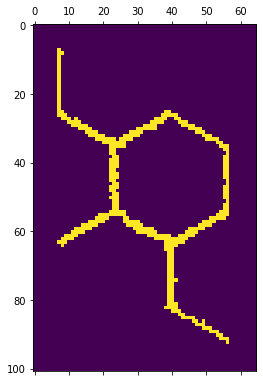

In [54]:
n =7
def MakeQuantisedGrid(inData: np.array, fltGridSize: float)->np.array:
    arrReturn = np.zeros([np.ceil(np.max(inData[:,0])/fltA+1+2*n).astype('int'),np.ceil(np.max(inData[:,1])/fltA+1+2*n).astype('int')])
    for j in inData:
        if j[4].astype('int') ==0:
            arrReturn[(np.floor(j[0]/fltA)+n).astype('int'), (np.floor(j[1]/fltA)+n).astype('int')] += 1
        arrReturn = arrReturn.astype('bool').astype('int') 
    return arrReturn
arrOut = MakeQuantisedGrid(MyData, fltA)
plt.matshow(arrOut)
plt.show()


In [55]:
arrEdge1 = gf.QuantisedVector(objTimeStep.GetCellVectors()[1,0:2]*(1/fltA))
arrEdge0 = gf.QuantisedVector(objTimeStep.GetCellVectors()[0,0:2]*(1/fltA))

In [56]:
def TranslateGBPoints(arrPoints: np.array, arrShift: np.array):
    for j in arrPoints:
        if arrOut[j[0], j[1]] ==1 or arrOut[j[0], j[1]] ==4 :
            arrOut[j[0]+arrShift[0], j[1]+arrShift[1]] = 1       

In [57]:
def CornerPointMove(arrStartPoint: np.array, arrShift: np.array, intSize: int):
    arrPoints = np.argwhere(arrOut[intSize-arrStartPoint[0]:intSize+arrStartPoint[0],
                                   intSize-arrStartPoint[1]:intSize+arrStartPoint[1]]==1)
    TranslateGBPoints(arrPoints, arrShift)

In [58]:
for k in range(n+1):
    TranslateGBPoints(arrEdge0 + np.array([n,n])+arrEdge1[k], arrEdge1[-1])
    TranslateGBPoints(arrEdge1 + np.array([n,n])+arrEdge0[k], arrEdge0[-1])
    TranslateGBPoints(arrEdge0 + np.array([n,n])+arrEdge1[-(k+1)], -arrEdge1[-1])
    TranslateGBPoints(arrEdge1 + np.array([n,n])+arrEdge0[-(k+1)], -arrEdge0[-1])
    CornerPointMove(np.array([n,n]), arrEdge1[-1],n)
    CornerPointMove(np.array([n,n]), arrEdge0[-1],n)
    CornerPointMove(np.array([n,n]), arrEdge0[-1]+arrEdge1[-1],n)
    


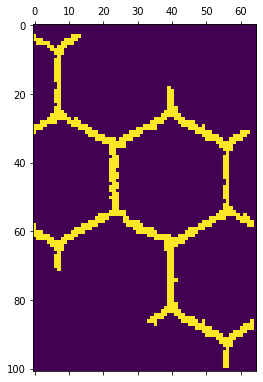

array([0, 0])

In [59]:
#tmpArr = np.argwhere(arrOut[0:arrEdge0[-1,0],0:n]==1)
plt.matshow(arrOut)
plt.show()
arrEdge0[0]

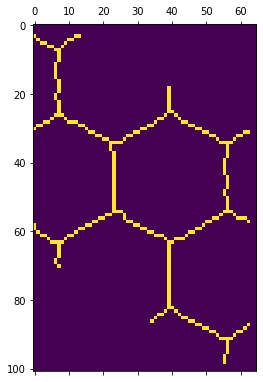

In [60]:
#arrOutSk = skeletonize(arrOut)
arrOutSk = thin(arrOut)
arrOutSk = skeletonize(arrOut)
#arrOutSk = medial_axis(arrOut)
arrOutSk = arrOutSk.astype('int')
plt.matshow(arrOutSk)
#pixel_graph, coordinates, degrees = skeleton_to_csgraph(arrOutSk)

In [61]:
def ClassifyGBPoints(arrPoints: np.array, m: int, blnFlagEndPoints = False)->np.array:
    arrTotal =np.zeros(4*m)
    intLow = int((m-1)/2)
    intHigh = int((m+1)/2)
    arrArgList = np.argwhere(arrPoints==1)
    for x in arrArgList: #loop through the array positions which have GB atoms
        arrCurrent = arrPoints[x[0]-intLow:x[0]+intHigh,x[1]-intLow:x[1]+intHigh] #sweep out a m x m square of array positions with
        intSwaps = 0
        if np.shape(arrCurrent) == (m,m): #centre j. This check avoids boundary points
            intValue = arrCurrent[0,0]
            arrTotal[:m ] = arrCurrent[0,:]
            arrTotal[m:2*m] =  arrCurrent[:,-1]
            arrTotal[2*m:3*m] = arrCurrent[-1,::-1]
            arrTotal[3*m:4*m] = arrCurrent[-1::-1,0]
            for k in arrTotal:
                if (k!= intValue): #the move has changed from grain (int 0) to grain boundary (int 1) or vice versa
                    intSwaps += 1
                    intValue = k
            if intSwaps == 6:
                if not (arrCurrent[0].all() == 1 or arrCurrent[-1].all() == 1 or arrCurrent[:,0].all() == 1 or arrCurrent[:,-1].all() ==1):
                    arrPoints[x[0],x[1]]=2 #this is a triple point
            if intSwaps < 4:
                if blnFlagEndPoints:
                    arrPoints[x[0],x[1]]=3   #this is where a GB terminates without being a triple point

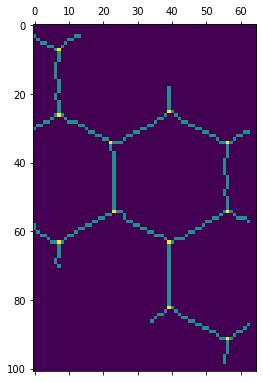

In [62]:
ClassifyGBPoints(arrOutSk,3)
plt.matshow(arrOutSk)

In [63]:
arrTriplePoints = np.argwhere(arrOutSk ==2)

In [64]:
arrTriplePoints

array([[ 7,  7],
       [25, 39],
       [26,  7],
       [34, 22],
       [34, 56],
       [54, 23],
       [54, 56],
       [63,  7],
       [63, 39],
       [82, 39],
       [91, 56]])

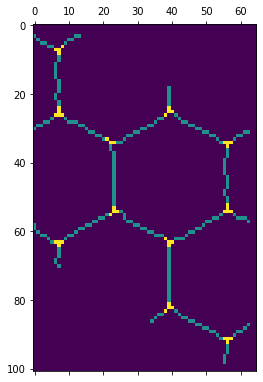

In [65]:
ClassifyGBPoints(arrOutSk,5, False)
plt.matshow(arrOutSk)

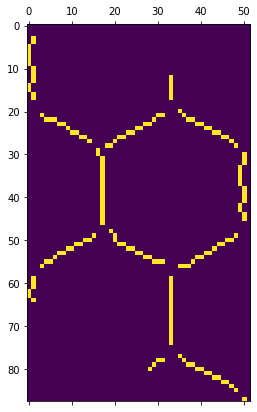

In [66]:
arrGBPoints = arrOutSk[n-1:-n,n-1:-n] ==1
arrGBPoints = arrGBPoints.astype('int')
plt.matshow(arrGBPoints)
plt.show()

In [67]:
# def ExtendQuantisedVector(inVector: np.array, intAmount)->np.array: #extends 
#     rtnVector = np.zeros([2])
#     intMaxCol =np.argmax(np.abs(inVector))
#     intMinCol = 1- intMaxCol
#     fltRatio = inVector[intMinCol]/inVector[intMaxCol]
#     rtnVector[intMaxCol] = inVector[intMaxCol]+ intAmount
#     rtnVector[intMinCol] = rtnVector[intMaxCol]*fltRatio
#     return QuantisedVector(rtnVector)


In [68]:
arrEdge0Ext = gf.ExtendQuantisedVector(arrEdge0[-1],2)
arrEdge1Ext = gf.ExtendQuantisedVector(arrEdge1[-1],2)
for j in range(0,np.shape(arrGBPoints)[0]-arrEdge0Ext[-1,0]):
    arrCurrent = arrEdge1Ext  +arrEdge0Ext[-1] + arrEdge0Ext[j]
    for k in arrCurrent:
        down = np.mod(k[0], np.shape(arrGBPoints)[0])
        across = np.mod(k[1], np.shape(arrGBPoints)[1])
        arrGBPoints[down,across] =0 
print(np.shape(arrCurrent), np.shape(arrGBPoints))

(52, 2) (88, 52)


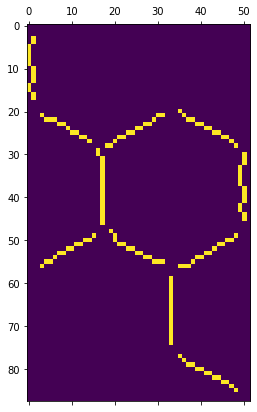

In [69]:
plt.matshow(arrGBPoints)
plt.show()
arrOnlyGBPoints = np.argwhere(arrGBPoints ==1)
arrOnlyGBPoints = arrOnlyGBPoints.astype('int')

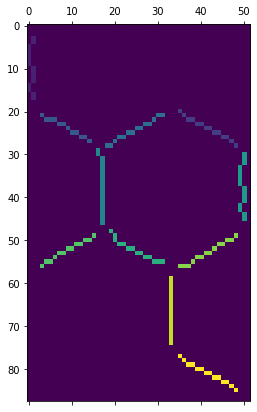

12


In [70]:
GBLabels = label(arrGBPoints)
plt.matshow(GBLabels)
plt.show()
print(len(np.unique(GBLabels)))

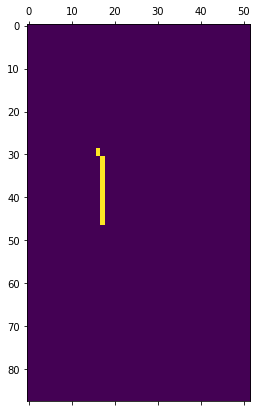

In [71]:
plt.matshow(GBLabels ==5)

In [72]:
arrRealPoints = np.zeros([len(arrTriplePoints),3])
arrRealPoints[:,0:2] = fltA*(arrTriplePoints-np.array([n-0.5,n-0.5]))
arrMovedPoints = objTimeStep.MoveToSimulationCell(arrRealPoints)
#print(arrMovedPoints)
# dctTripleLines = {}
# j = 0
# lstIndices = list(range(len(arrRealPoints)))
# lstPoints = arrRealPoints[0]
# for j in  range(len(lstIndices)):
#     for i in lstIndices:
#         if objPostProcess.PeriodicMinimumDistance(arrRealPoints[i],arrRealPoints[j]) < fltA:
#             lstPoints[j].append(arrRealPoints[i])
#             lstIndices.remove(i)
            
            

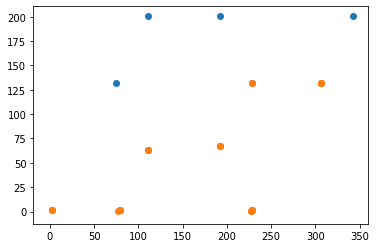

In [73]:
plt.scatter(arrRealPoints[:,0],arrRealPoints[:,1])
plt.scatter(arrMovedPoints[:,0],arrMovedPoints[:,1])
plt.show()

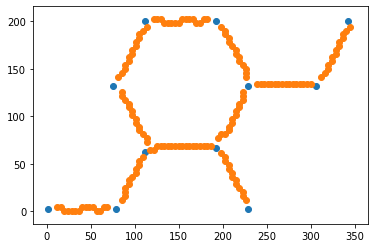

In [74]:
arrRealGBPoints = np.zeros([len(arrOnlyGBPoints),3])
arrRealGBPoints[:,0:2] = fltA*arrOnlyGBPoints
#arrRealGBPoints = objTimeStep.MoveToSimulationCell(arrRealGBPoints)
plt.scatter(arrRealPoints[:,0],arrRealPoints[:,1])
plt.scatter(arrRealGBPoints[:,0], arrRealGBPoints[:,1])
plt.show()

In [75]:
# def SetGrid(arrGrid: np.array, arrPoints: np.array, intValue):
#     intLow = int((intValue-1)/2)
#     intHigh = int((intValue+1)/2)
#     for j in arrPoints:
#         arrGrid[j[0].astype('int')+intLow:j[0].astype('int')+intHigh, j[1].astype('int')+intLow:j[1].astype('int')+intHigh] = intValue
# SetGrid(arrOut, arrTriplePoints,5)    

In [76]:
arrTestPoints = np.zeros([len(arrRealGBPoints),3])
for index, j in enumerate(arrRealGBPoints):
    arrTestPoints[index] = objPostProcess.FindNonGrainMean(j,2*fltA)

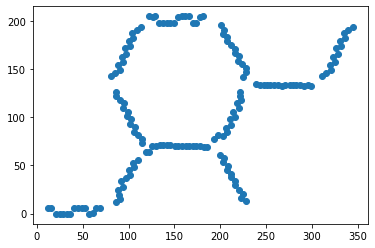

In [77]:
plt.scatter(arrTestPoints[:,0],arrTestPoints[:,1])
#plt.scatter(arrRealPoints[:,0], arrRealPoints[:,1])

In [78]:
arrTestPoints2 = objTimeStep.MoveToSimulationCell(arrTestPoints)

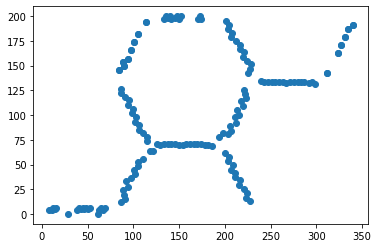

In [79]:
plt.scatter(arrTestPoints2[:,0],arrTestPoints2[:,1])
#plt.scatter(arrTestPoints[:,0],arrTestPoints[:,1])
plt.show()

In [80]:
kdTripleTree= sc.spatial.KDTree(arrRealPoints)

In [81]:
def FindRectangularRegion(arrPoints: np.array, inVector: np.array)->np.array:
    fltLength = np.lingalg.norm(inVector, axis = 0)
    arrPoints = arrPoints - inVector
    arrParallelIndices = np.argwhere(np.matmul(arrPoints, inVector) <= fltLength)
    
        

In [82]:
np.argwhere(arrRealPoints == arrRealPoints[1])

array([[ 0,  2],
       [ 1,  0],
       [ 1,  1],
       [ 1,  2],
       [ 2,  2],
       [ 3,  2],
       [ 4,  2],
       [ 5,  2],
       [ 6,  2],
       [ 7,  2],
       [ 8,  1],
       [ 8,  2],
       [ 9,  1],
       [ 9,  2],
       [10,  2]])

In [83]:
def PeriodicPattern(inPoint: np.array):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-83-7624930ca90a>, line 2)